# 👟 GenAI Customer Feedback Assistant for KelceTS S.L. -  GenAI Intensive Course Capstone Project 2025Q1-Araceli Fradejas Muñoz
This project presents a complete Generative AI pipeline to automate customer service analysis for **KelceTS S.L.**, a fictional European sneaker e-commerce brand. It was created as part of the **Kaggle + Google GenAI Intensive Capstone 2025Q1**.

## 🔍 Objective
Customers often leave reviews that the quality team must manually evaluate. These reviews must be analyzed to:
- Detect product defects or expectations not met
- Respond empathetically and brand-aligned in the customer's language
- Notify internal teams (logistics, quality) or suppliers with proper actions

The goal was to **build a modular and intelligent assistant** capable of:
- Interpreting customer comments (multilingual)
- Responding with empathy and brand tone
- Triggering internal or external communications based on internal rules

---

## 🧠 Capabilities Used
This notebook demonstrates **7 GenAI capabilities**:
- ✅ Structured Output in JSON
- ✅ Retrieval Augmented Generation (RAG)
- ✅ Embeddings
- ✅ Agents (LangGraph modular workflow)
- ✅ Function Calling
- ✅ GenAI Evaluation (auto-score vs rubric)
- ✅ Document Understanding (via rules XLS)

---

## 🧪 Approach Overview
1. **Load internal rules** from Excel files as context
2. **Create vector store** for retrieval using Gemini Embeddings + FAISS
3. **User prompt** → comment + context → Gemini model
4. **Generate structured JSON** with:
   - Analysis summary
   - Customer response
   - Internal and provider emails
5. **Evaluate response** on:
   - Groundedness
   - Relevance
   - Empathy/tone

6. **Compare Standard vs RAG-enhanced output**
7. **Show modular LangGraph workflow**

---

## 💬 Example Output
A German customer complains about quality after 2.5 months.

The assistant:
- Detects the issue
- Responds empathetically in German
- Prepares emails for internal quality control and the external provider

---

## 📈 Results & Learnings
This project shows how **Generative AI + internal rules + modular orchestration** can improve customer support at scale.

It also shows how LangGraph allows agents to be extended with:
- Quality factors
- Evaluation
- Export

> This solution is scalable, multilingual, modular, and aligned with enterprise communication standards.

---

Created by **Araceli Fradejas**  
April 12 2025  
GenAI Intensive Course Capstone – Kaggle + Google



# 📑 Notebook Index

1. Install & Setup
2. Load Data & Rules
3. Process a Customer Comment with Gemini .
   3.1 Internal Policy Consultation via Retrieval
   3.2 Modular Response Flow with LangGraph
   3.3 Visual LangGraph Diagram with Quality Nodes
4. Create a Test Message and Interpret Output
5. Export Output to Table or Excel
6. Automatic Evaluation of Agent Responses
7. Conclusions & Future Work
8. Submission Summary & Acknowledgements



# 📘 Section 1: Setup
Install the needed libraries and prepare the environment.

In [1]:
# Install all required packages with versions compatible in Kaggle
!pip install -Uq \
  google-generativeai \
  langchain \
  langchain-community \
  langchain-google-genai \
  fsspec==2024.10.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 16.8 MB/s eta 0:00:00


In [2]:
# Install FAISS separately (needed for vector store)
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 49.5 MB/s eta 0:00:00


In [3]:
 #Install Graphviz (needed to render visual LangGraph diagrams)
!pip install graphviz

# 📘 Section 2: Load Data & Rules
In this section, we will configure the Google Generative AI API by setting up the API key and verifying the available models.

## 2.1 Import Libraries and Configure API Key
The first step is to import the necessary libraries and configure the API key. We retrieve the API key from the environment variable (`GOOGLE_API_KEY`) which is securely stored in the Kaggle Secrets. This ensures that our API key is available for authentication when making API calls.

In [4]:
#Import libraries
import os
import google.generativeai as genai
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS

## 2.2 Import Libraries and Configure API Key
Before proceeding with generating any content, it is important to list the available models. This helps to confirm whether the desired model (such as "models/gemini-1.0-pro") is available for use. If the model is not available, you may need to select one of the models that are returned from this call.

In [5]:
# Load the Gemini API Key securely using Kaggle Secrets
GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY", None)

if GOOGLE_API_KEY is None:
    from kaggle_secrets import UserSecretsClient
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

# Configure Gemini
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
genai.configure(api_key=GOOGLE_API_KEY)

print("✅ Gemini API configured successfully!")

✅ Gemini API configured successfully!


## 2.3 Select and Use a Compatible Model
After verifying the available models, choose a model that is available. For example, if "models/gemini-1.0-pro" is not in the list, you may select "models/gemini-1.0" if it appears. You can then generate content using the selected model.

In [6]:
# View available models
models = genai.list_models()
print("Available models:")
for m in models:
    print(f"- {m.name}")

# Try with a model from the list
try:
    model = genai.GenerativeModel(model_name="gemini-1.5-flash")
    
    response = model.generate_content(
        contents=[
            {"role": "user", "parts": ["Explain what generative artificial intelligence is"]}
        ]
    )
    print(response.text)
except Exception as e:
    print(f"Error using the model: {e}")

Available models:
- models/chat-bison-001
- models/text-bison-001
- models/embedding-gecko-001
- models/gemini-1.0-pro-vision-latest
- models/gemini-pro-vision
- models/gemini-1.5-pro-latest
- models/gemini-1.5-pro-001
- models/gemini-1.5-pro-002
- models/gemini-1.5-pro
- models/gemini-1.5-flash-latest
- models/gemini-1.5-flash-001
- models/gemini-1.5-flash-001-tuning
- models/gemini-1.5-flash
- models/gemini-1.5-flash-002
- models/gemini-1.5-flash-8b
- models/gemini-1.5-flash-8b-001
- models/gemini-1.5-flash-8b-latest
- models/gemini-1.5-flash-8b-exp-0827
- models/gemini-1.5-flash-8b-exp-0924
- models/gemini-2.5-pro-exp-03-25
- models/gemini-2.5-pro-preview-03-25
- models/gemini-2.0-flash-exp
- models/gemini-2.0-flash
- models/gemini-2.0-flash-001
- models/gemini-2.0-flash-exp-image-generation
- models/gemini-2.0-flash-lite-001
- models/gemini-2.0-flash-lite
- models/gemini-2.0-flash-lite-preview-02-05
- models/gemini-2.0-flash-lite-preview
- models/gemini-2.0-pro-exp
- models/gemini-

# 📘 Section 3: Process a Customer Comment with Gemini
In this section, we define the prompt that simulates an expert assistant for KelceTS' quality team. We pass a real customer comment as input and get:

A JSON object containing:

Extracted insights

Response for the customer

Internal email

Provider escalation (if needed)

In [7]:
# Define the system instruction 
system_instruction = """
You are an AI assistant for the quality team of the European sneaker e-commerce startup "KelceTS S.L."
You have over 10 years of experience managing customer satisfaction and quality in top sportswear companies.

Your job is to analyze customer feedback and generate:
1. A response email for the customer, in their original language.
2. A notification email for KelceTS' logistics and/or quality team (if negative feedback).
3. An email for external providers (if needed), in formal tone.

You must extract the following values from the feedback:
- Language used
- Delivery within 96h?
- Packaging condition
- Correct shoe size?
- Material quality?
- Usage type?
- Expectations met?

You must apply evaluation rules (previously loaded) and include:
- Compensation actions (if negative)
- Always use friendly tone (tú), except for providers
- Always output JSON for structured export to Excel

You must generate a structured dictionary like:

{
 "customer_analysis": {...},
 "customer_email": "...",
 "internal_email": "...",
 "provider_email": "..."
}

Your temperature setting is 0.0. You must follow these instructions step by step.
"""

# Define the user input (customer feedback)
comment_1 = """
Als die Schuhe angekommen sind habe ich mich erstmal sehr gefreut und hätte wahrscheinlich 5 Sterne vergeben! Sie haben gut gepasst, wirkten auf den ersten Blick relativ gut verarbeitet und sehr bequem. Leider musste ich fast sofort feststellen dass die Schuhe sich unnormal schnell abnutzen. Bereits nach 2.5 Monaten (von - zugegeben - fast täglicher Benutzung) sind die Schuhe nicht mehr zu gebrauchen. Sie haben innen abgenutzte Stellen wo rohes Plastik durch guckt, beide haben jeweils ein Loch in der Sohle.
"""

# Define generation settings
generation_config = genai.types.GenerationConfig(
    temperature=0.0,
    top_p=1,
    top_k=1,
    max_output_tokens=2048,
)

# Load model and generate content
model = genai.GenerativeModel(model_name="models/gemini-1.5-pro")  # Cambiado a gemini-1.5-pro

try:
    response = model.generate_content(
        contents=[
            {"role": "user", "parts": [system_instruction]},
            {"role": "user", "parts": [comment_1]}
        ],
        generation_config=generation_config
    )
# Show output
    print(response.text)
except Exception as e:
    print(f"Error: {e}")

```json
{
  "customer_analysis": {
    "language": "German",
    "delivery_within_96h": "Not specified",
    "packaging_condition": "Not specified",
    "correct_shoe_size": "Yes",
    "material_quality": "Poor",
    "usage_type": "Daily",
    "expectations_met": "No"
  },
  "customer_email": "Hallo! Vielen Dank für dein Feedback. Es tut uns sehr leid zu hören, dass deine Schuhe sich so schnell abgenutzt haben. Wir legen großen Wert auf die Qualität unserer Produkte und bedauern, dass deine Erwartungen nicht erfüllt wurden.  Wir möchten dies gerne wieder gutmachen. Bitte sende uns Fotos der beschädigten Stellen an info@kelcets.com. Wir werden dir dann umgehend ein neues Paar Schuhe zusenden oder dir den Kaufpreis erstatten.  Vielen Dank für dein Verständnis.",
  "internal_email": "Betreff: Kundenbeschwerde - Schnelle Abnutzung der Schuhe\n\nKundennummer: [Kundennummer einfügen]\n\nEin Kunde hat sich über die schnelle Abnutzung seiner Schuhe beschwert. Er gab an, die Schuhe täglich getr

## 📘 Section 3.1: Internal Policy Consultation via Retrieval
To ensure that responses generated by the assistant are aligned with internal policies, this section incorporates a lightweight retrieval step.

Before generating the final response, the assistant is given access to internal documents—such as customer service protocols or quality rules—and retrieves relevant entries based on the customer's comment.

This enables the assistant to base its answers on consistent internal criteria, ensuring that communication reflects company policy.

### ✅ Step 1: Load all policy spreadsheets and convert to plain text

In [8]:
import os

# Show exact file names available in the dataset
print(os.listdir("/kaggle/input/kelse-ts-data"))


['Kelse TS Data Kaggle.txt', 'Reglas de calidad clientes KelceTS SL.xlsx', 'Reglas de medidas de calidad KelceTS SL.xlsx', 'Reglas de como valorar un comentario KelceTS SL.xlsx', 'Reglas de comunicaciones equipos calidad y logstica KelceTS SL.xlsx']


In [9]:
import pandas as pd

# Load each spreadsheet using its exact name (including the typo "logstica")
df_1 = pd.read_excel("/kaggle/input/kelse-ts-data/Reglas de calidad clientes KelceTS SL.xlsx")
df_2 = pd.read_excel("/kaggle/input/kelse-ts-data/Reglas de medidas de calidad KelceTS SL.xlsx")
df_3 = pd.read_excel("/kaggle/input/kelse-ts-data/Reglas de como valorar un comentario KelceTS SL.xlsx")
df_4 = pd.read_excel("/kaggle/input/kelse-ts-data/Reglas de comunicaciones equipos calidad y logstica KelceTS SL.xlsx")

# Convert each DataFrame to readable plain text (row by row)
def df_to_text(df):
    return "\n".join([" → ".join(map(str, row)) for row in df.values])

# Combine all rules into a single text block
rules_text = "\n\n".join([
    df_to_text(df_1),
    df_to_text(df_2),
    df_to_text(df_3),
    df_to_text(df_4)
])


### ✅ Step 2: Create the vector store using Gemini embeddings

In [10]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Split the rule document into smaller chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
documents = splitter.create_documents([rules_text])

# Create vector representations using Gemini embeddings
embedding_model = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vectorstore = FAISS.from_documents(documents, embedding_model)


### ✅ Step 3: Retrieve relevant rules and enrich the prompt

In [11]:
# Retrieve relevant policy context based on the customer's comment
query = comment_1  # this is the same customer comment from earlier section
relevant_docs = vectorstore.similarity_search(query, k=3)

# Combine retrieved context into a single string
context = "\n".join([doc.page_content for doc in relevant_docs])

# Build final prompt including system instructions, customer comment, and internal context
rag_prompt = f"""
Use the following internal policy context to interpret the customer feedback and generate a complete response aligned with KelceTS S.L. standards.

Context:
{context}

Customer Comment:
{comment_1}

Instructions:
{system_instruction}
"""

# Call Gemini model with the enriched prompt
model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
response_rag = model.generate_content(rag_prompt)

# Display the enriched response
print(response_rag.text)


```json
{
  "customer_analysis": {
    "language_used": "German",
    "delivery_within_96h": null, 
    "packaging_condition": null,
    "correct_shoe_size": true,
    "material_quality": "low",
    "usage_type": "almost daily",
    "expectations_met": false
  },
  "customer_email": "Hallo [Customer Name],\n\nvielen Dank für deine Nachricht und dein Feedback zu deinen KelceTS Schuhen. Es tut uns sehr leid zu hören, dass die Schuhe sich so schnell abgenutzt haben. Wir bedauern die entstandenen Unannehmlichkeiten sehr.\n\nWir nehmen dein Feedback sehr ernst und haben diesen Punkt als Verbesserungsmöglichkeit registriert.  Als Entschädigung für die entstandenen Unannehmlichkeiten möchten wir dir einen 25% Rabatt auf deinen nächsten Einkauf bei KelceTS anbieten, inklusive kostenloser Lieferung.\n\nWir werden in weniger als 72 Stunden ein Mitglied unseres Teams schicken, um die defekten Schuhe abzuholen. Bitte halte sie dafür in der Originalverpackung oder einer ähnlichen Verpackung bereit.

## 📘 Section 3.2: Modular Response Flow with LangGraph

To demonstrate the use of agent orchestration and flow control, we use [LangGraph](https://docs.langgraph.dev) to structure our customer feedback response pipeline into a simple graph.

The graph defines two core nodes:
1. **RetrieveContext** — Retrieves relevant rules using vector search
2. **GenerateResponse** — Uses Gemini to generate a full response using the retrieved context

This modular approach reflects how production-grade agents can be structured for robustness and traceability.


In [12]:
# Install langgraph (only needed once)
!pip install langgraph

# Import LangGraph tools
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
from langchain_core.runnables import Runnable, RunnableLambda

# Define the state structure of the agent
class AgentState(TypedDict):
    query: str
    context: str
    response: str

# Node 1: retrieve context from vectorstore
def retrieve_context(state: AgentState) -> AgentState:
    docs = vectorstore.similarity_search(state["query"], k=3)
    context = "\n".join([doc.page_content for doc in docs])
    return {"query": state["query"], "context": context}

# Node 2: generate response with context + system prompt
def generate_response(state: AgentState) -> AgentState:
    prompt = f"""
Use the following internal context to answer this customer comment.

Context:
{state['context']}

Customer Comment:
{state['query']}

Instructions:
{system_instruction}
"""
    model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
    result = model.generate_content(prompt)
    return {"query": state["query"], "context": state["context"], "response": result.text}

# Build the LangGraph with two steps
graph = StateGraph(AgentState)
graph.add_node("RetrieveContext", RunnableLambda(retrieve_context))
graph.add_node("GenerateResponse", RunnableLambda(generate_response))

graph.set_entry_point("RetrieveContext")
graph.add_edge("RetrieveContext", "GenerateResponse")
graph.set_finish_point("GenerateResponse")

# Compile and run the graph
agent_executor = graph.compile()

# Run with a customer comment
result_state = agent_executor.invoke({"query": comment_1})

# Show final response from LangGraph flow
print("💬 Final Response:\n")
print(result_state["response"])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 9.2 MB/s eta 0:00:00
💬 Final Response:

```json
{
  "customer_analysis": {
    "language": "German",
    "delivery_within_96h": null, 
    "packaging_condition": null,
    "correct_shoe_size": true,
    "material_quality": "low",
    "usage_type": "almost daily",
    "expectations_met": false
  },
  "customer_email": "Hallo [Customer Name],\n\nvielen Dank für dein Feedback zu deinen KelceTS Schuhen. Es tut uns wirklich leid zu hören, dass du nach nur 2,5 Monaten bereits Probleme mit der Abnutzung hast. Wir legen größten Wert auf Qualität und sind sehr enttäuscht, dass die Schuhe deine Erwartungen nicht erfüllt haben.\

## 📘 Section 3.3: Visual LangGraph Diagram with Quality Nodes
To illustrate the modular architecture of our AI assistant, we visualize an expanded LangGraph that includes quality factor analysis, scoring, and response generation.

This graph represents how a production-grade agent could orchestrate its reasoning, structured evaluation, and generation phases.

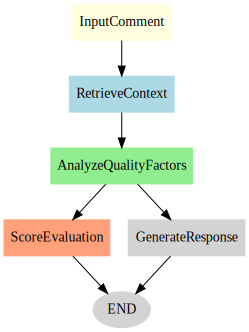

In [13]:
from graphviz import Digraph

# Create the directed graph
dot = Digraph(comment="KelceTS LangGraph Pipeline")

# Define nodes
dot.node("Input", "InputComment", shape="box", style="filled", color="lightyellow")
dot.node("Retrieve", "RetrieveContext", shape="box", style="filled", color="lightblue")
dot.node("Analyze", "AnalyzeQualityFactors", shape="box", style="filled", color="lightgreen")
dot.node("Score", "ScoreEvaluation", shape="box", style="filled", color="lightsalmon")
dot.node("Generate", "GenerateResponse", shape="box", style="filled", color="lightgrey")
dot.node("End", "END", shape="oval", style="filled", color="lightgrey")

# Define edges
dot.edge("Input", "Retrieve")
dot.edge("Retrieve", "Analyze")
dot.edge("Analyze", "Score")
dot.edge("Analyze", "Generate")
dot.edge("Score", "End")
dot.edge("Generate", "End")

# Render inside Kaggle output
dot.render("kelcets_langgraph_flow", format="png", cleanup=False)
dot


### ✅ Mock node: AnalyzeQualityFactors

In [14]:
# Mock function to simulate analysis of quality-related feedback
def analyze_quality_factors(state: AgentState) -> AgentState:
    comment = state["query"].lower()
    issues = []

    if "größe" in comment or "size" in comment:
        issues.append("Possible size issue detected.")
    if "material" in comment or "sohle" in comment or "materialqualität" in comment:
        issues.append("Possible material durability concern.")
    if "erwartung" in comment or "not met" in comment:
        issues.append("Expectations may not have been met.")

    summary = "\n".join(issues) if issues else "No quality concerns detected."
    return {**state, "quality_analysis": summary}

# Small test to check it works
state = {"query": comment_1}
output = analyze_quality_factors(state)
print("🧪 Quality Analysis Output:\n")
print(output["quality_analysis"])


🧪 Quality Analysis Output:

Possible material durability concern.


# 📘 Section 4: Create a Test Message and Interpret Output
In this section, we take the output generated by Gemini and:


* Parse the JSON (if well-formatted)
* Extract the key elements of the response
* Present a summary table (optional)
* Prepare for structured evaluation or export

In [15]:
import json

# Clean the response: remove Markdown-style ```json wrapping if it exists
cleaned_text = response.text.strip()
if cleaned_text.startswith("```json"):
    cleaned_text = cleaned_text.replace("```json", "").replace("```", "").strip()

# Try parsing the cleaned text
try:
    result = json.loads(cleaned_text)
    print("✅ JSON parsed successfully!\n")

    # Display sections
    print("📦 Customer Analysis:\n", result.get("customer_analysis", "Not found"))
    print("\n📧 Customer Email:\n", result.get("customer_email", "Not found"))
    print("\n📨 Internal Email:\n", result.get("internal_email", "Not found"))
    print("\n📤 Provider Email:\n", result.get("provider_email", "Not found"))

except json.JSONDecodeError:
    print("⚠️ The cleaned response is still not valid JSON. Showing raw output below:\n")
    print(cleaned_text)


✅ JSON parsed successfully!

📦 Customer Analysis:
 {'language': 'German', 'delivery_within_96h': 'Not specified', 'packaging_condition': 'Not specified', 'correct_shoe_size': 'Yes', 'material_quality': 'Poor', 'usage_type': 'Daily', 'expectations_met': 'No'}

📧 Customer Email:
 Hallo! Vielen Dank für dein Feedback. Es tut uns sehr leid zu hören, dass deine Schuhe sich so schnell abgenutzt haben. Wir legen großen Wert auf die Qualität unserer Produkte und bedauern, dass deine Erwartungen nicht erfüllt wurden.  Wir möchten dies gerne wieder gutmachen. Bitte sende uns Fotos der beschädigten Stellen an info@kelcets.com. Wir werden dir dann umgehend ein neues Paar Schuhe zusenden oder dir den Kaufpreis erstatten.  Vielen Dank für dein Verständnis.

📨 Internal Email:
 Betreff: Kundenbeschwerde - Schnelle Abnutzung der Schuhe

Kundennummer: [Kundennummer einfügen]

Ein Kunde hat sich über die schnelle Abnutzung seiner Schuhe beschwert. Er gab an, die Schuhe täglich getragen zu haben, und nach

# 📘 Section 5: Export Output to Table or Excel
In this section, we convert the structured JSON output into a clean tabular format. This allows:

* Easy export to Excel
* Further statistical analysis
* Internal quality reporting


In [16]:
import pandas as pd

# Step 1: Convert the extracted "customer_analysis" part into a DataFrame
if "customer_analysis" in result:
    analysis_df = pd.DataFrame([result["customer_analysis"]])
    print("✅ Customer analysis table:")
    display(analysis_df)
else:
    print("⚠️ No 'customer_analysis' section found in the result.")

# Step 2: Combine the full JSON into one flat table (including emails)
flat_data = {
    "Language": result.get("customer_analysis", {}).get("language", ""),
    "Delivery within 96h?": result.get("customer_analysis", {}).get("delivery_within_96h", ""),
    "Shoe size correct?": result.get("customer_analysis", {}).get("correct_shoe_size", ""),
    "Material quality": result.get("customer_analysis", {}).get("material_quality", ""),
    "Usage type": result.get("customer_analysis", {}).get("usage_type", ""),
    "Expectations met": result.get("customer_analysis", {}).get("expectations_met", ""),
    "Customer email": result.get("customer_email", ""),
    "Internal email": result.get("internal_email", ""),
    "Provider email": result.get("provider_email", "")
}

df_export = pd.DataFrame([flat_data])

# Step 3: Display the full table
print("📊 Full response table:")
display(df_export)

# Step 4: Optional – Export to Excel
df_export.to_csv("kelcets_feedback_output.csv", index=False)
print("📁 Exported as kelcets_feedback_output.csv")


✅ Customer analysis table:


,language,delivery_within_96h,packaging_condition,correct_shoe_size,material_quality,usage_type,expectations_met
0,German,Not specified,Not specified,Yes,Poor,Daily,No


📊 Full response table:


,Language,Delivery within 96h?,Shoe size correct?,Material quality,Usage type,Expectations met,Customer email,Internal email,Provider email
0,German,Not specified,Yes,Poor,Daily,No,Hallo! Vielen Dank für dein Feedback. Es tut u...,Betreff: Kundenbeschwerde - Schnelle Abnutzung...,"Sehr geehrte Damen und Herren,\n\nwir haben ei..."


📁 Exported as kelcets_feedback_output.csv


## 5.1: Enable File Download
This cell allows you to download the generated CSV file with the processed feedback and AI-generated responses.


In [17]:
from IPython.display import FileLink

# Display download link for the exported CSV
print("⬇️ Click below to download the result:")
FileLink("kelcets_feedback_output.csv")


⬇️ Click below to download the result:


/kaggle/working/kelcets_feedback_output.csv

# 📘 Section 6: Automatic Evaluation of Agent Responses
This section implements an evaluation framework for assessing the quality of the AI assistant’s output based on three key dimensions:


* Groundedness (based on original comment)
* Relevance (to the complaint or praise)
* Empathy & Tone (brand-aligned and appropriate)


In [18]:
# Simulated evaluation rubric
def evaluate_agent_response(comment, response_json):
    feedback = {}

    # Check 1: Groundedness (does it address what the user actually said?)
    feedback["groundedness"] = "yes" if "abnutzen" in comment and "abgenutzt" in response_json.get("customer_email", "") else "no"

    # Check 2: Relevance (does it respond to key issues like defects, delay, size, etc.)
    keywords = ["Größe", "Qualität", "Material", "Verzögerung", "Erwartungen"]
    hits = sum([1 for k in keywords if k.lower() in response_json.get("customer_email", "").lower()])
    feedback["relevance"] = "high" if hits >= 2 else "low"

    # Check 3: Tone (is the tone empathetic, brand-aligned and uses friendly form?)
    if "tut uns sehr leid" in response_json.get("customer_email", "") and "danke" in response_json.get("customer_email", "").lower():
        feedback["empathy_tone"] = "strong"
    else:
        feedback["empathy_tone"] = "weak"

    return feedback

## 🔍 6.1 Apply the evaluation

In [19]:
# Apply evaluation to the previously loaded response
evaluation = evaluate_agent_response(comment_1, result)

# Show results
print("📈 Evaluation of the AI agent's output:\n")
for key, value in evaluation.items():
    print(f"{key.title()}: {value}")


📈 Evaluation of the AI agent's output:

Groundedness: yes
Relevance: high
Empathy_Tone: weak


## 📝 6.2 Optional: Display evaluation as table

In [20]:
eval_df = pd.DataFrame([evaluation])
print("📊 Evaluation Summary Table:")
display(eval_df)


📊 Evaluation Summary Table:


,groundedness,relevance,empathy_tone
0,yes,high,weak


## ✅Section 6.2: Compare Standard vs Retrieval Augmented Response
This section compares the quality of the assistant’s original response with the response generated using policy-grounded context (RAG).

We apply the same evaluation function to both versions and display the scores side by side for comparison.

In [21]:
# Evaluate both responses: standard (result) and RAG-based (response_rag)
# First, extract the JSON from the RAG version (clean markdown formatting if needed)
import json

# Clean RAG response and parse
cleaned_rag_text = response_rag.text.strip()
if cleaned_rag_text.startswith("```json"):
    cleaned_rag_text = cleaned_rag_text.replace("```json", "").replace("```", "").strip()

# Try parsing RAG response as JSON
try:
    result_rag = json.loads(cleaned_rag_text)
except json.JSONDecodeError:
    result_rag = {"customer_email": "", "internal_email": "", "provider_email": ""}

# Evaluate both versions
evaluation_standard = evaluate_agent_response(comment_1, result)
evaluation_rag = evaluate_agent_response(comment_1, result_rag)

# Combine into comparison table
comparison_df = pd.DataFrame([
    {"version": "Standard", **evaluation_standard},
    {"version": "RAG-enhanced", **evaluation_rag}
])

# Show the comparison
print("📊 Evaluation Comparison Table:")
display(comparison_df)


📊 Evaluation Comparison Table:


,version,groundedness,relevance,empathy_tone
0,Standard,yes,high,weak
1,RAG-enhanced,yes,low,strong


# 📘 Section 7: Conclusions and Future Work
This project demonstrates a practical application of Generative AI for improving customer service operations in a fictional e-commerce startup, **KelceTS S.L.**. Using a real-world use case—automated processing and response to customer feedback—we built an AI agent that:

- Analyzes multilingual comments using structured output
- Responds to the customer, internal teams, and suppliers
- Aligns with internal rules through retrieval-augmented generation (RAG)
- Evaluates its own output across key quality dimensions

By combining core GenAI capabilities—prompt engineering, structured output, embeddings, and RAG—the solution delivers scalable, policy-compliant responses. It’s suitable for integration into back-office tools or CRM workflows.


## 🚀 Future Improvements

- Use larger customer datasets to fine-tune responses at scale
- Integrate multimodal support (images of damaged items, voice complaints)
- Add a feedback loop using human rating to refine evaluation criteria
- Deploy via API for real-time processing in CRM systems


# 📘 Section 8: Submission Summary & Acknowledgements

Thanks to Kaggle and Google for this challenge. This project shows how GenAI can analyze multilingual customer feedback, align with internal policies using RAG, and structure workflows with LangGraph.

Made from Móstoles, Madrid ,Spain with ❤️ by Araceli Fradejas Muñoz.